In [1]:
import warnings
from itertools import product
from copy import deepcopy
from rich.progress import track
from os.path import join

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LogisticRegression

from mlresearch.utils import set_matplotlib_style, parallel_loop
from mlresearch.utils._check_pipelines import check_random_states
from recgame.recourse import NFeatureRecourse
from recgame.populations import BasePopulation
from recgame.environments import (
    BankLoanApplication2,
    BankLoanApplication3,
    WillingnessEnvironment,
)
from recgame.visualization import (
    simulations_scores_panel,
    simulations_success_rate_panels,
)
from recgame.utils import generate_synthetic_data

# Environment setup

In [2]:
set_matplotlib_style(
    16, 
    
    **{"lines.markersize": 1, "axes.labelsize": 14, "legend.fontsize": 16, "xtick.labelsize": 12, "ytick.labelsize": 12, "font.family":"Times"}
)

SAVE_PATH = "../assets/multi-agent-dynamic-counterfactual-recourse/analysis/"
N_RUNS = 20

# Some variables to define the problem
RNG_SEED = 42
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100

# Functions definition

In [3]:
def _plot_metric(
    metric,
    relevant_results,
    ax,
    values=None,
    alpha_err=0.2,
    alpha_line=1,
    gauss_filter=False,
    c=None,
):
    if values is None:
        metric_values = np.array(
            [
                [res_.metadata_[i][metric] for i in range(len(res_.metadata_))]
                for res_ in relevant_results
            ]
        )
    else:
        metric_values = values

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        y_mean = np.nanmean(metric_values, axis=0)
        y_err = np.nanstd(metric_values, axis=0)
    y_min = y_mean - y_err
    y_max = y_mean + y_err

    x = np.arange(metric_values.shape[1])
    ax.fill_between(x, y_min, y_max, alpha=alpha_err, color=c)
    if gauss_filter:
        sr_smooth = gaussian_filter1d(
            np.where(np.isnan(y_mean), y_mean[~np.isnan(y_mean)].mean(), y_mean),
            sigma=5,
        )
        ax.plot(x, y_mean, alpha=alpha_line, c=c)
        ax.plot(x, sr_smooth, c=c, label=metric.replace("_", " ").title())
    else:
        ax.plot(
            x, y_mean, label=metric.replace("_", " ").title(), alpha=alpha_line, c=c
        )
    return ax


def n_runs_simulations_scores_panel(results, adaptation_list, new_agents_list):
    fig, axes = plt.subplots(
        len(adaptation_list),
        len(new_agents_list),
        figsize=(10, 10),
        layout="constrained",
        sharey=True,
        sharex=True,
    )

    unpacked_results = [setting for result in results for setting in result]
    for adapt, nagents in track(list(product(adaptation_list, new_agents_list))):
        i = adaptation_list.index(adapt)
        j = new_agents_list.index(nagents)
        ax1 = axes[i, j]
        ax2 = ax1.twinx()

        relevant_results = [
            res_[-1]
            for res_ in unpacked_results
            if (res_[0]["adaptation"] == adapt) and (res_[0]["new_agents"] == nagents)
        ]

        # threshold
        p1 = _plot_metric("threshold", relevant_results, ax1, c="#3584e4")
        ax1.tick_params(axis="y", labelcolor="#3584e4")

        # success rate
        succ_rate = np.array(
            [
                np.concatenate([[np.nan], res_.success_rate(1, res_.step_ + 1)])
                for res_ in relevant_results
            ]
        )
        p2 = _plot_metric(
            "success_rate",
            relevant_results,
            ax2,
            succ_rate,
            alpha_err=0.1,
            alpha_line=0.2,
            gauss_filter=True,
            c="#d75c5c",
        )
        ax2.tick_params(axis="y", labelcolor="#d75c5c")

        # ax1.set_ylim([0.38, 0.72])  # threshold - blue
        ax1.set_ylim([0, 1])  # threshold - blue
        ax2.set_ylim([0, 1])  # success rate - red

        if j != len(new_agents_list) - 1:
            ax2.set(yticklabels=[])

        # if i == 0 and j == len(new_agents_list) - 1:
        #     lines1, labels1 = ax1.get_legend_handles_labels()
        #     lines2, labels2 = ax2.get_legend_handles_labels()
        #     ax2.legend(lines1 + lines2, labels1 + labels2, loc=0, fontsize=16)

        ax1.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
        ax2.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))

    for i in range(len(adaptation_list)):
        axes[i, 0].set_ylabel(f"{adaptation_list[i]}", fontsize=18)

    for j in range(len(new_agents_list)):
        axes[-1, j].set_xlabel(f"{new_agents_list[j] / 10}", fontsize=18)

    fig.supxlabel(r"Number of New Agents", fontsize=24)
    fig.supylabel("Adaptation Rate", fontsize=24)

    return fig, axes

In [4]:
def stack_uncertainties(results, adaptation_list, new_agents_list, ax=None, y_label=True):
    if ax is None:
        fig, ax = plt.subplots(
            1,
            1,
            figsize=(5, 5),
            layout="constrained",
            sharey=True,
            sharex=True,
        )
        plot_legend = True
    else:
        plot_legend = False
    
    colors = ["#9abff1", "#2167bc", "#1f2c3d"] # adaptation rate
    linestyle = ["solid", "dashed", "dotted"] # new agents
    unpacked_results = [setting for result in results for setting in result]
    
    for adapt, nagents in track(list(product(adaptation_list, new_agents_list))):
        i = adaptation_list.index(adapt)
        j = new_agents_list.index(nagents)
    
        relevant_results = [
            res_[-1]
            for res_ in unpacked_results
            if (res_[0]["adaptation"] == adapt) and (res_[0]["new_agents"] == nagents)
        ]
    
        # success rate
        succ_rate = np.array(
            [
                np.concatenate([[np.nan], res_.success_rate(1, res_.step_ + 1)])
                for res_ in relevant_results
            ]
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            y_mean = np.nanmean(succ_rate, axis=0)
            
        sr_smooth = gaussian_filter1d(
            np.where(np.isnan(y_mean), y_mean[~np.isnan(y_mean)].mean(), y_mean),
            sigma=5,
        )
    
        x = np.arange(sr_smooth.shape[0])
        ax.plot(x, sr_smooth, linestyle=linestyle[j], c=colors[i], label=f"Adapt: {adapt}, N Ag: {nagents}")
    
    if y_label:
        ax.set_ylabel("Success Rate")
    ax.set_xlabel("Time steps")
    
    # Set up legend
    if plot_legend:
        lines = ax.get_lines()
        legend1 = plt.legend([lines[i] for i in [-3,-2,-1]], new_agents_list, title="\# Agents", bbox_to_anchor=(1.04, 0.58), loc="center left", borderaxespad=0)
        legend2 = plt.legend([lines[i] for i in [0,3,6]], adaptation_list, title="Adaptation", bbox_to_anchor=(1.04, 0.42), loc="center left", borderaxespad=0)
        fig.add_artist(legend1)
        fig.add_artist(legend2)
        return fig, ax
    else:
        return ax

In [5]:
def _get_data(unpacked_results, adapt, nagents, new_col_name=None):
    relevant_results = [
        res_[-1].agents_info()
        for res_ in unpacked_results
        if (res_[0]["adaptation"] == adapt) and (res_[0]["new_agents"] == nagents)
    ]
    agents_info_all = []
    for ai in relevant_results:
        # ai = ai[~ai.favorable_step.isna()|ai.n_failures > 0].copy()
        ai["positive_outcome"] = (~ai.favorable_step.isna()).astype(int)
        
        ai["Initial Score"] = pd.cut(ai["original_score"], 5, labels=["Lowest", "Low", "Mean", "High", "Highest"])
        agents_info_all.append(ai)
    
    # return pd.concat(agents_info_all).groupby(["Initial Score"]).mean().rename(columns={"n_failures": new_col_name})[new_col_name]
    return pd.concat(agents_info_all).groupby(["Initial Score"]).mean().rename(columns={"positive_outcome": new_col_name})[new_col_name]


In [6]:
# results = all_runs_bla3
# results2 = all_runs_will
# adaptation_list = ADAPTATION_BLA3[::2]
# new_agents_list = NEW_AGENTS_BLA3[::2]

def n_runs_failures_panel(adaptive_results, innate_results, adaptation_list, new_agents_list):
    fig, axes = plt.subplots(
        len(adaptation_list),
        len(new_agents_list),
        figsize=(7, 7),
        layout="constrained",
        sharey=True,
        sharex=True,
    )
    
    unpacked_results = [setting for result in adaptive_results for setting in result]
    unpacked_results2 = [setting for result in innate_results for setting in result]
    for adapt, nagents in track(list(product(adaptation_list, new_agents_list))):
        i = adaptation_list.index(adapt)
        j = new_agents_list.index(nagents)
    
        n_failures = _get_data(unpacked_results, adapt, nagents, "Adaptive")
        n_failures2 = _get_data(unpacked_results2, adapt, nagents, "Innate")
        legend = True if i == 0 and j == (len(new_agents_list) - 1) else False
        ax = pd.concat([n_failures, n_failures2], axis=1).plot.bar(ax=axes[i,j], color=["#2167bc", "#1f2c3d"], legend=legend)
    
    for i in range(len(adaptation_list)):
        axes[i, 0].set_ylabel(f"{adaptation_list[i]}")
    
    for j in range(len(new_agents_list)):
        axes[-1, j].set_xlabel(f"{new_agents_list[j] / 10}")
    
    # fig.suptitle("Success rate")
    fig.supxlabel(r"\# New Agents (x-axis: Initial Score)")
    fig.supylabel("Adaptation (y-axis: Rate of Positive Outcomes)")
    return fig, axes



# Bank Loan application - Gaussian adaptation

In [7]:
# Meta-simulation variables
N_LOANS_BLA3 = [10]  # number of loans is fixed
ADAPTATION_BLA3 = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_BLA3 = [8, 9, 10, 11, 12]
N_LOANS_BLA3, ADAPTATION_BLA3, NEW_AGENTS_BLA3

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [8]:
all_runs_bla3 = []
for i, random_state in enumerate(check_random_states(RNG_SEED, N_RUNS)):
    df, y, categorical = generate_synthetic_data(
        N_AGENTS, N_CONTINUOUS, N_CAT, random_state
    )

    lr = LogisticRegression(random_state=random_state).fit(df, y)
    population = BasePopulation(df, categorical=categorical)
    recourse = NFeatureRecourse(lr, n_features=2)

    def _meta_simulation(params):
        loans, adapt, agents = params
        environment = BankLoanApplication3(
            deepcopy(population),
            deepcopy(recourse),
            n_loans=loans,
            adaptation=adapt,
            new_agents=agents,
            random_state=random_state,
        )
        try:
            environment.run_simulation(50)
        except ValueError:
            pass

        return {
            "n_loans": loans,
            "adaptation": adapt,
            "new_agents": agents,
        }, environment

    results_bla3 = parallel_loop(
        _meta_simulation,
        list(product(N_LOANS_BLA3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)),
        n_jobs=-1,
        progress_bar=True,
        description=f"Run #{i}",
    )
    all_runs_bla3.append(results_bla3)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

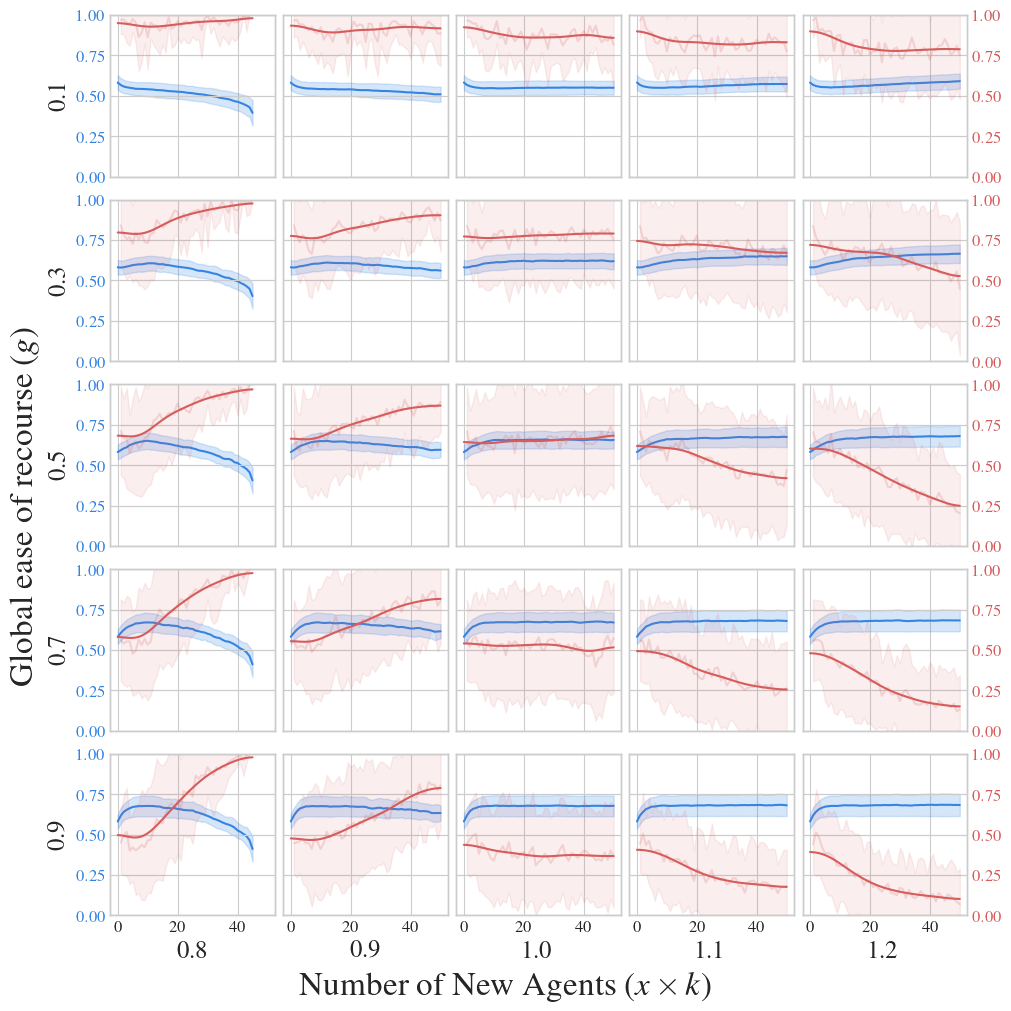

In [9]:
fig, axes = n_runs_simulations_scores_panel(all_runs_bla3, ADAPTATION_BLA3, NEW_AGENTS_BLA3)
fig.supylabel("Global ease of recourse ($g$)", fontsize=24)
fig.supxlabel(r"Number of New Agents ($x \times k$)", fontsize=24)
plt.savefig(
    join(SAVE_PATH, f"multiple_runs_{N_RUNS}_gaussian_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# Bank Loan application - Binary adaptation

In [10]:
# Meta-simulation variables
N_LOANS_BLA2 = [10]  # number of loans is fixed
ADAPTATION_BLA2 = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_BLA2 = [8, 9, 10, 11, 12]
N_LOANS_BLA2, ADAPTATION_BLA2, NEW_AGENTS_BLA2

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [11]:
all_runs_bla2 = []
for i, random_state in enumerate(check_random_states(RNG_SEED, N_RUNS)):
    df, y, categorical = generate_synthetic_data(
        N_AGENTS, N_CONTINUOUS, N_CAT, random_state
    )

    lr = LogisticRegression(random_state=random_state).fit(df, y)
    population = BasePopulation(df, categorical=categorical)
    recourse = NFeatureRecourse(lr, n_features=2)

    def _meta_simulation(params):
        loans, adapt, agents = params
        environment = BankLoanApplication2(
            deepcopy(population),
            deepcopy(recourse),
            n_loans=loans,
            adaptation=adapt,
            new_agents=agents,
            random_state=random_state,
        )
        try:
            environment.run_simulation(50)
        except (ValueError, KeyError):
            pass

        return {
            "n_loans": loans,
            "adaptation": adapt,
            "new_agents": agents,
        }, environment

    results_bla2 = parallel_loop(
        _meta_simulation,
        list(product(N_LOANS_BLA2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)),
        n_jobs=-1,
        progress_bar=True,
        description=f"Run #{i}",
    )
    all_runs_bla2.append(results_bla2)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

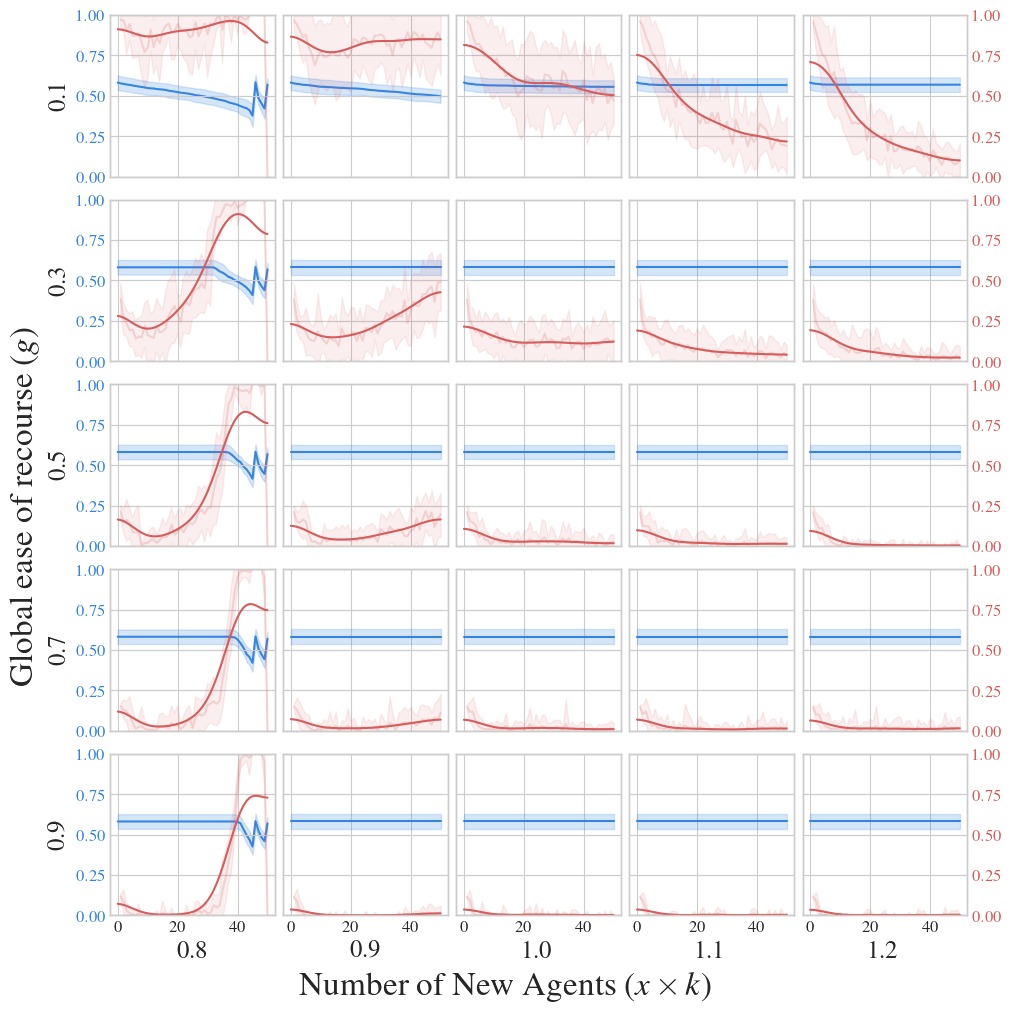

In [12]:
fig, axes = n_runs_simulations_scores_panel(all_runs_bla2, ADAPTATION_BLA2, NEW_AGENTS_BLA2)
fig.supylabel("Global ease of recourse ($g$)", fontsize=24)
fig.supxlabel(r"Number of New Agents ($x \times k$)", fontsize=24)
plt.savefig(
    join(SAVE_PATH, f"multiple_runs_{N_RUNS}_binary_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# Willingness Environment

In [13]:
# Meta-simulation variables
N_LOANS_WILL = [10]  # number of loans is fixed
ADAPTATION_WILL = [0.1, 0.3, 0.5, 0.7, 0.9]
NEW_AGENTS_WILL = [8, 9, 10, 11, 12]
N_LOANS_WILL, ADAPTATION_WILL, NEW_AGENTS_WILL

([10], [0.1, 0.3, 0.5, 0.7, 0.9], [8, 9, 10, 11, 12])

In [14]:
all_runs_will = []
for i, random_state in enumerate(check_random_states(RNG_SEED, N_RUNS)):
    df, y, categorical = generate_synthetic_data(
        N_AGENTS, N_CONTINUOUS, N_CAT, random_state
    )

    lr = LogisticRegression(random_state=random_state).fit(df, y)
    population = BasePopulation(df, categorical=categorical)
    recourse = NFeatureRecourse(lr, n_features=2)

    def _meta_simulation(params):
        loans, adapt, agents = params
        environment = WillingnessEnvironment(
            deepcopy(population),
            deepcopy(recourse),
            n_loans=loans,
            adaptation=adapt,
            new_agents=agents,
            random_state=random_state,
        )
        try:
            environment.run_simulation(50)
        except ValueError:
            pass

        return {
            "n_loans": loans,
            "adaptation": adapt,
            "new_agents": agents,
        }, environment

    results_will = parallel_loop(
        _meta_simulation,
        list(product(N_LOANS_WILL, ADAPTATION_WILL, NEW_AGENTS_WILL)),
        n_jobs=-1,
        progress_bar=True,
        description=f"Run #{i}",
    )
    all_runs_will.append(results_will)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

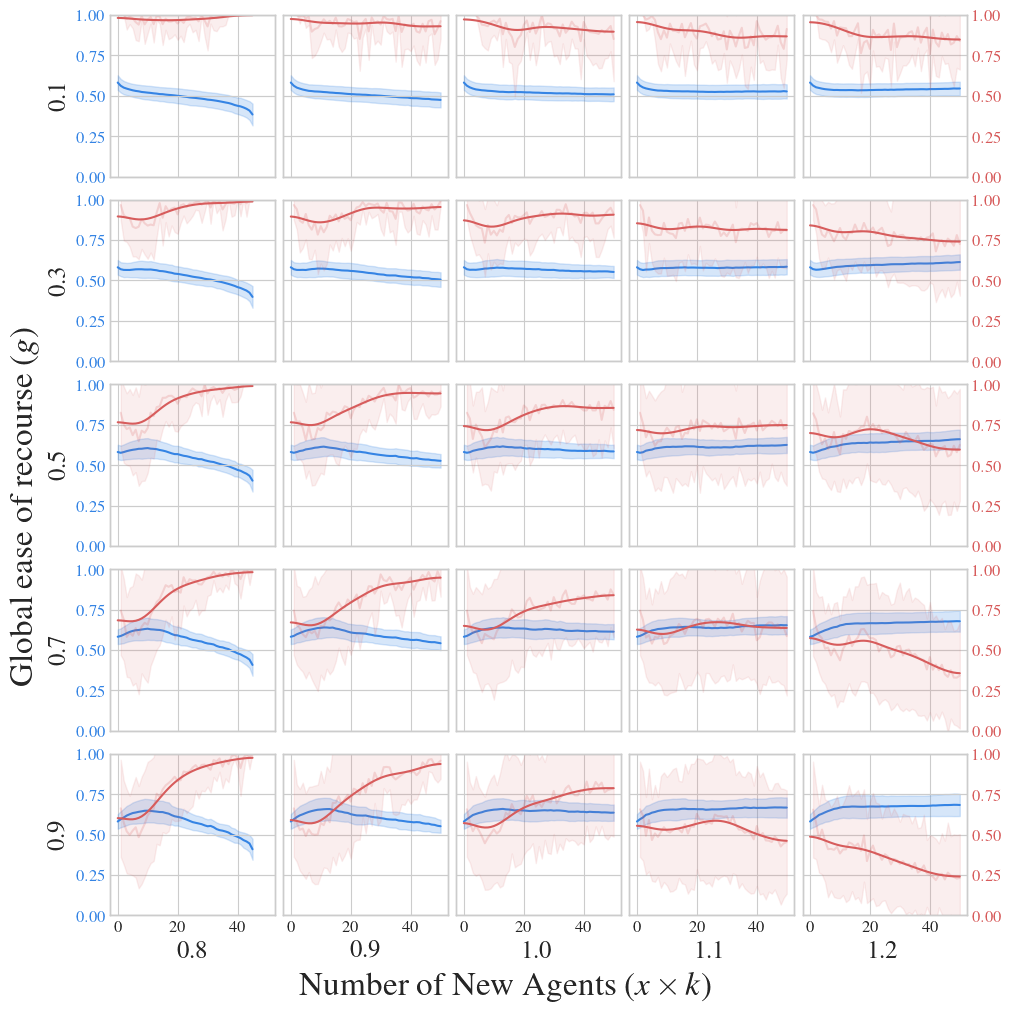

In [15]:
fig, axes = n_runs_simulations_scores_panel(all_runs_will, ADAPTATION_WILL, NEW_AGENTS_WILL)
fig.supylabel("Global ease of recourse ($g$)", fontsize=24)
fig.supxlabel(r"Number of New Agents ($x \times k$)", fontsize=24)
plt.savefig(
    join(SAVE_PATH, f"multiple_runs_{N_RUNS}_willingness_panel.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

# Additional visualizations

Output()

Output()

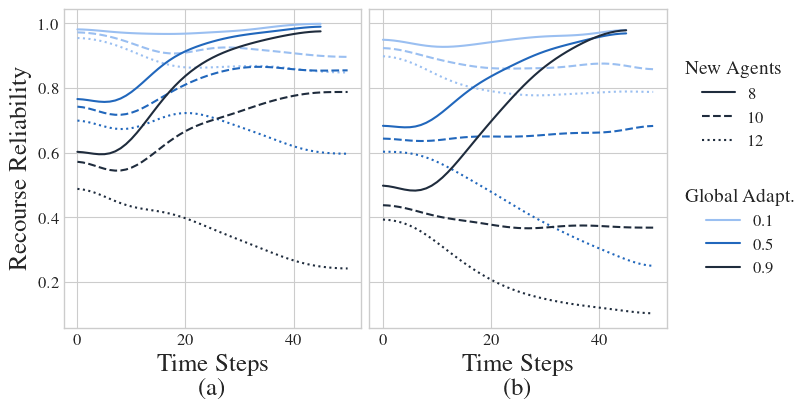

In [16]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(8, 4),
    layout="constrained",
    sharey=True,
    sharex=True,
)

# Innate
stack_uncertainties(all_runs_will, ADAPTATION_WILL[::2], NEW_AGENTS_WILL[::2], ax=axes[0], y_label=False)
axes[0].set_xlabel("Time Steps\n(a)", fontsize=18) # (a) Innate

# Adaptive
stack_uncertainties(all_runs_bla3, ADAPTATION_BLA3[::2], NEW_AGENTS_BLA3[::2], ax=axes[1], y_label=False)
axes[1].set_xlabel("Time Steps\n(b)", fontsize=18) # (b) Adaptive

axes[0].set_ylabel("Recourse Reliability", fontsize=18)

lines = axes[0].get_lines()
legend1 = plt.legend([lines[i] for i in [-3,-2,-1]], NEW_AGENTS_BLA3[::2], title="New Agents", bbox_to_anchor=(1.04, 0.7), loc="center left", borderaxespad=0, fontsize=12, title_fontsize=14)
legend2 = plt.legend([lines[i] for i in [0,3,6]], ADAPTATION_BLA3[::2], title="Global Adapt.", bbox_to_anchor=(1.04, 0.3), loc="center left", borderaxespad=0, fontsize=12, title_fontsize=14)
fig.add_artist(legend1)
#fig.add_artist(legend2)

plt.savefig(
    join(SAVE_PATH, f"success_rate_comparison.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

Output()

KeyError: 0

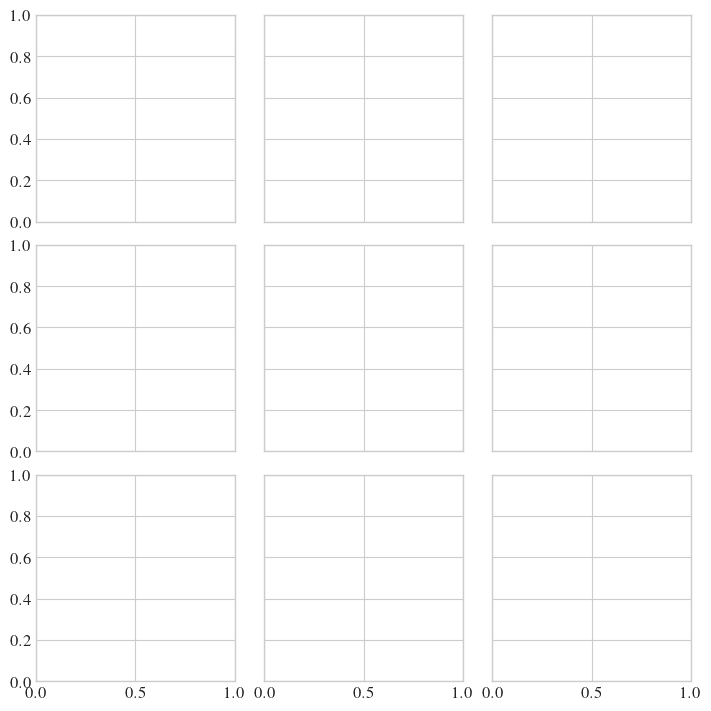

In [17]:
n_runs_failures_panel(results_bla3, results_will, ADAPTATION_BLA3[::2], NEW_AGENTS_BLA3[::2])
# plt.savefig(
#     join(SAVE_PATH, f"rate_positive_outcomes_comparison.pdf"),
#     format="pdf",
#     bbox_inches="tight",
# )
plt.show()

In [ ]:
def n_runs_failures_row(adaptive_results, innate_results, adaptation_list, new_agents_value):
    fig, axes = plt.subplots(
        1,
        len(adaptation_list),
        figsize=(7, 4),
        layout="constrained",
        sharey=True,
        sharex=True,
    )
    
    unpacked_results = [setting for result in adaptive_results for setting in result]
    unpacked_results2 = [setting for result in innate_results for setting in result]
    for adapt in track(adaptation_list):
        i = adaptation_list.index(adapt)
    
        n_failures = _get_data(unpacked_results, adapt, new_agents_value, "Cont. + Flex.")
        n_failures2 = _get_data(unpacked_results2, adapt, new_agents_value, "Cont. + Const.")
        # legend = True if i == 0 and j == (len(new_agents_list) - 1) else False
        ax = pd.concat([n_failures, n_failures2], axis=1).plot.bar(ax=axes[i], color=["#2167bc", "#1f2c3d"], legend=False)
    
    for i in range(len(adaptation_list)):
        axes[i].set_xlabel(f"{adaptation_list[i] / 10}", fontsize=16)
    
    # NOTE: modify first value in tuple to center legend
    fig.legend(*ax.get_legend_handles_labels(), bbox_to_anchor=(0.2, 1.0, .6, .01), loc='lower left', ncols=2)
    # fig.legend(*ax.get_legend_handles_labels(), loc='outside upper center', ncols=2)

    # fig.suptitle("Success rate")
    fig.supxlabel(r"Adaptation (x-axis: Initial Score)", fontsize=18)
    axes[0].set_ylabel("Positive Outcome Rate", fontsize=18)
    return fig, axes

In [ ]:
n_runs_failures_row(results_bla3, results_will, ADAPTATION_BLA3[::2], NEW_AGENTS_BLA3[-1])
plt.savefig(
    join(SAVE_PATH, f"rate_positive_outcomes_comparison.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()